## V9

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta

pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Use 3 decimal places in output display
pd.set_option("display.precision", 3)

CATEGORY_FREQ = 100

In [2]:
df_shops = pd.read_csv("shops.csv")
df_shops.describe()

,shop_id
count,60.00000
mean,29.50000
std,17.46425
min,0.00000
25%,14.75000
50%,29.50000
75%,44.25000
max,59.00000


In [3]:
# get valid shop id
def valid_shop_id(id):
    if id == 0:
        return 57
    if id == 1:
        return 58
#    if id == 23:
#        return 24
    if id == 11:
        return 10
    if id == 40:
        return 39 
    return id

def shop_type(shop):
    #types = ['ТК', 'ТЦ', 'ТРК', 'ТРЦ']
    p = re.compile(r"(Т[РКЦ]+)")
    r = p.search(shop)
    if r is not None: return r.group(1) 
    if 'нлайн' in shop: return 'Онлайн'
    if 'нтернет' in shop: return 'Онлайн'
    return 'Магазин'

# get city
def shop_city(shop):
    p = re.compile(r"^([а-яА-Я\.]*)")
    r = p.search(shop)
    if r is not None: return r.group(1) 
    return 'Unknown'

#df_shops['valid_id'] = df_shops['shop_id'] 

In [4]:
df_shops.drop([0,1], inplace=True)

In [5]:
df_shops['city'] = df_shops['shop_name'].apply(lambda x: shop_city(x))
df_shops['type'] = df_shops['shop_name'].apply(lambda x: shop_type(x))
df_shops['mega'] = df_shops['shop_name'].str.contains('мега', case=False).astype(int)

In [6]:
df_shops = df_shops.set_index('shop_id')
df_shops.tail()

,shop_name,city,type,mega
shop_id,,,,
55,Цифровой склад 1С-Онлайн,Цифровой,Онлайн,0
56,"Чехов ТРЦ ""Карнавал""",Чехов,ТРЦ,0
57,"Якутск Орджоникидзе, 56",Якутск,Магазин,0
58,"Якутск ТЦ ""Центральный""",Якутск,ТЦ,0
59,"Ярославль ТЦ ""Альтаир""",Ярославль,ТЦ,0


In [7]:
 df_shops.iloc[25]['type']

'ТЦ'

In [8]:
df_categories = pd.read_csv("item_categories.csv", index_col='item_category_id')
df_categories.describe()

,item_category_name
count,84
unique,84
top,Игры PC - Стандартные издания
freq,1


In [9]:
df_categories['category'] = df_categories['item_category_name'].str.split('[-(]', n=0).str[0].str.strip()
df_categories['digital'] = df_categories['item_category_name'].str.contains('цифра', case=False).astype(int)

In [10]:
df_categories.index.names = ['category_id']
df_categories.head()

,item_category_name,category,digital
category_id,,,
0,PC - Гарнитуры/Наушники,PC,0
1,Аксессуары - PS2,Аксессуары,0
2,Аксессуары - PS3,Аксессуары,0
3,Аксессуары - PS4,Аксессуары,0
4,Аксессуары - PSP,Аксессуары,0


In [11]:
df_items = pd.read_csv("items.csv", index_col='item_id')
df_items.describe()

,item_category_id
count,22170.00000
mean,46.29075
std,15.94149
min,0.00000
25%,37.00000
50%,40.00000
75%,58.00000
max,83.00000


In [12]:
df_items.head()

,item_name,item_category_id
item_id,,
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40
1,!ABBYY FineReader 12 Professional Edition Full...,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,40
4,***КОРОБКА (СТЕКЛО) D,40


In [13]:
#df_items["label1"] = df_items["item_name"].str.lower().str.extract(r"\((.*?)\)")[0]
df_items["label1"] = df_items["item_name"].str.lower().str.extractall(r"\((.*?)\)")[0].str.split(',').groupby(level=0).apply(lambda l: [item.strip() for sublist in l for item in sublist])
df_items["label2"] = df_items["item_name"].str.lower().str.extractall(r"\[(.*?)\]")[0].str.split(',').groupby(level=0).apply(lambda l: [item.strip() for sublist in l for item in sublist])
#label1 = df_items["label1"].value_counts()
#[print(k) for k in label1.keys() if label1[k] < 2]
df_items[["label1", "label2"]].head(20)

,label1,label2
item_id,,
0,[пласт.],NaN
1,NaN,"[pc, цифровая версия]"
2,[unv],NaN
3,[univ],NaN
4,[стекло],NaN
5,[uni],NaN
6,[uni],NaN
7,[uni],NaN
8,NaN,NaN


In [14]:
label_corrections = {'univ': 'unv'
                      ,'uni': 'unv'
                      ,'mp3-cd': ['mp3', 'cd']
                      ,'mp3-cd+dvd': ['mp3', 'cd', 'dvd']
                      ,'ps3/xbox 360/pc/mac': ['xbox 360', 'ps3', 'pc', 'mac']
                      ,'x360/ps3/pc/mac': ['xbox 360', 'ps3', 'pc', 'mac']
                      ,'xbox 360/pc/mac': ['xbox 360', 'pc', 'mac']
                      ,'pc/ xbox 360': ['xbox 360', 'pc']
                      ,'ps3/pc/mac': ['ps3', 'pc', 'mac']
                      ,'ps3/pc': ['ps3', 'pc']
                      ,'с поддержкой ps4': 'ps4'
                      ,'с поддержкой ps3 и ps vita': ['ps3', 'ps vita']
                      ,'cd-digipack': ['cd','digipack']
                      ,'mp3-dvd': ['mp3', 'dvd']
                      ,'dvd-book': ['dvd', 'book']
                      ,'dvd+книга': ['dvd', 'book']
                      ,'dvd-digipack': ['dvd', 'digipack']
                      ,'dvd box': ['dvd', 'box']
                      ,'dvd-box': ['dvd', 'box']
                      ,'dvd- box': ['dvd', 'box']
                      ,'dvd+ bd': ['dvd', 'bd']
                      ,'cd-box': ['cd', 'box']
                      ,'dvd-pack': 'dvd'
                      ,'dvdpack': 'dvd'
                      ,'1dvd+5 в подарок': 'dvd'
                      ,'+cd': 'cd'
                      ,'+ cd': 'cd'
                      ,'+ dvd': 'dvd'
                      ,'8 cd': 'cd'
                      ,'2dvd': 'dvd'
                      ,'2 dvd': 'dvd'
                      ,'2 изд-е': '2-е издание'
                      ,'2-е изд.': '2-е издание'
                      ,'2-е изд': '2-е издание'
                      ,'2 издание': '2-е издание'
                      ,'изд.2': '2-е издание'
                      ,'изд.3': '3-е издание'
                      ,'2-е изд. перераб и доп': ['2-е издание','переработано','дополнено']
                      ,'3 изд-е': '3-е издание'
                      ,'3-е изд-е': '3-е издание'
                      ,'переработанное': 'переработано'
                      ,'испр и доп': ['исправлено', 'дополнено']
                      ,'исправ. и доп.': ['исправлено', 'дополнено']
                      ,'перераб и доп': ['переработано', 'дополнено']
                      ,'испр и доп.': ['исправлено', 'дополнено']
                      ,'2bd': 'bd'
                      ,'bd 4k': 'bd'
                      ,'3d bd+bd': ['3d', 'bd']
                      ,'dvd+bd+3d открытка': ['3d', 'bd', 'dvd', 'коллекционная открыка']
                      ,'3d bd+bd+коллекционная открыка': ['3d', 'bd', 'коллекционная открыка']
                      ,'bd+коллекционная открытка': ['bd', 'коллекционная открыка']
                      ,'3d bd': ['3d','bd']
                      ,'3 диска 3d bd': ['3d','bd']
                      ,'pc-dvd': ['pc', 'dvd']
                      ,'dvd+bd': ['dvd', 'bd']
                      ,'коробка': 'box'
                      ,'фирм.': 'фирм'
                      ,'только для ms kinect': 'kinect'
                      ,'толькоя для ms kinect': 'kinect'
                      ,'только для kinect': 'kinect'
                      ,'только для ps move': 'pc move'
                      ,'с поддержкой ms kinect': 'kinect'
                      ,'с поддержкой ps move': 'pc move'
                      ,'с поддержкой move': 'pc move'
                      ,'c поддержкой ps move': 'pc move'
                      ,'требуется ps move': 'pc move'
                      ,'с поддержкой 3d': '3d'
                      ,'рус.в.': 'русская версия'
                      ,'рус.в': 'русская версия'
                      ,'рус': 'русская версия'
                      ,'предзаказ': 'preorder'
                      ,'по предзаказам': 'preorder'
                      ,'digpack': 'digipack'
                      ,'1 устройство/1год': ['1 устройство','1 год']
                      ,'1 устройство/2года': ['1 устройство','2 года']
                      ,'лицензия на 1 год на 1 пк': ['1 устройство','1 год']
                      ,'лицензия на 1 год на 2 пк': ['2 устройства','1 год']
                      ,'лицензия на 1 год на 3 пк': ['3 устройства','1 год']
                      ,'лицензия на 1 год на 5 пк': ['5 устройств','1 год']
                      ,'лицензия на 2 года на 1 пк': ['1 устройство','2 года']
                      ,'лицензия на 2 года на 2 пк': ['2 устройства','2 года']
                      ,'лицензия на 6 месяцев на 1 пк': ['1 устройство','6 месяцев']
                      ,'3 устройства / 1 год': ['3 устройства','1 год']
                      ,'лицензия на 1 год 2 пк': ['2 устройства','1 год']
                      ,'лицензия на 2 года 1 пк': ['1 устройство','2 года']
                      ,'лицензия на 2 года 2 пк': ['2 устройства','2 года']
                      ,'лицензия на 6 месяцев 1 пк': ['1 устройство','6 месяцев']
                      ,'2пк / 1 год': ['2 устройства','1 год']
                      ,'англ. в.': 'английская версия'
                      ,'англ.в': 'английская версия'
                      ,'англ.в.': 'английская версия'
                      ,'англ': 'английская версия'
                      ,'1пк / 1 год': ['1 устройство','1 год']
                      ,'3пк / 1 год': ['3 устройства','1 год']
                      ,'предзаказ1': 'preorder'
                      ,'предзаказ2': 'preorder'
                      ,'предзаказ3': 'preorder'
                      ,'2пк / 1год': ['2 устройства','1 год']
                      ,'2 пк/1 год': ['2 устройства','1 год']
                      ,'2 пк / 1 год': ['2 устройства','1 год']
                      ,'1 смартфон / 1 год': ['1 устройство','1 год']
                      ,'3 пк / 1 год': ['3 устройства','1 год']
                      ,'full eng': 'английская версия'
                      ,'eng': 'английская версия'
                      ,'англ.в.рус.с.': ['английская версия', 'русские субтитры']
                      ,'пожизненная лицензия на 3пк': '3 устройства'
                      ,'срок действия лицензии 1 год': '1 год'
                      ,'рукоятка для ps move controller в виде пистолета для стрельбы': 'pc move'
                      ,'контроллер движений ps move : cech-zcm1r bx: scee': 'pc move'
                      ,'зарядная станция/подставка для контроллера ps move': 'pc move'
                      ,'рукоятка для ps move controller в виде автомата для стрельбы и навигации': 'pc move'
                      ,'камера ps eye + контроллер движений ps move + демо-диск': 'pc move'
                      ,'подписка на 1 год': '1 год'
                      ,'1 пк': '1 устройство'
                      ,'на 1 год': '1 год'
                      ,'лицензия на 1 год': '1 год'
                      ,'3 года': '3 года'
                      ,'2 пк': '2 устройства'
                      ,'3 пк': '3 устройства'
                      ,'подписка на 6 месяцев': '6 месяцев'
                      ,'russian': 'русская версия'
                      ,'англ.в.рус.д.': ['английская версия','русская документация']
                      ,'книга + cd': ['book','cd']
                      ,'english': 'английская версия'
                      ,'4 dvd': 'dvd'
                      ,'3d bd+bd+dvd': ['3d', 'bd', 'dvd']
                      ,'3dvd': 'dvd'
                      ,'5dvd': 'dvd'
                      ,'48 dvd': 'dvd'
                      ,'мистерия регион': 'регион'
                      ,'13 dvd': 'dvd'
                      ,'21 dvd': 'dvd'
                      ,'11dvd': 'dvd'
                      ,'12dvd': 'dvd'
                      ,'18 dvd': 'dvd'
                      ,'колл. 9 dvd': ['dvd', 'колл']
                      ,'колл. 7 dvd': ['dvd', 'колл']
                      ,'колл. 5 dvd': ['dvd', 'колл']
                      ,'колл 9 dvd': ['dvd', 'колл']
                      ,'колл. 10 dvd': ['dvd', 'колл']
                      ,'коллекц. 16 dvd': ['dvd', 'колл']
                      ,'3 dvd': 'dvd'
                      ,'4dvd': 'dvd'
                      ,'6 dvd': 'dvd'
                      ,'колл. 4 dvd': ['dvd', 'колл']
                      ,'3bd': 'bd'
                      ,'23 bd': 'bd'
                      ,'24 bd': 'bd'
                      ,'4bd': 'bd'
                      ,'2 bd': 'bd'
                      ,'3 bd': 'bd'
                      ,'подар': 'подарочный'
                      ,'подар.': 'подарочный'
                      ,'5 dvd': 'dvd'
                      ,'колл.': 'колл'
                      ,'bd+cd': ['bd', 'cd']
                      ,'3 bd + 3 dvd + кольцо': ['bd', 'dvd']
                      ,'3 bd + 3 dvd': ['bd', 'dvd']
                      ,'6dvd': 'dvd'
                      ,'bd + dvd': ['bd', 'dvd']
                      ,'dvd+3d bd': ['dvd', '3d', 'bd']
                      ,'11 bd': 'bd'
                      ,'11 bd+закладки 2': 'bd'
                      ,'11 bd+закладки': 'bd'
                      ,'11 bd+значки': 'bd'
                      ,'3d+2d': '3d'
                      ,'коллекционное издание': 'колл'
                      ,'8dvd': 'dvd'
                      ,'uni регион.': ['unv', 'регион']
                      ,'dvd+ 3d bd': ['dvd', '3d', 'bd']
                      ,'вольга регион': 'регион'
                      ,'регион.': 'регион'
                      ,'dvd + bd': ['dvd', 'bd']
                      ,'3d bd + 2dvd': ['3d', 'bd', 'dvd']
                      ,'9bd': 'bd'
                      ,'14 dvd': 'dvd'
                      ,'15 dvd + трон+7 открыток': 'dvd'
                      ,'5 bd': 'bd'
                      ,'5 bd+яйцо+открытки': 'bd'
                      ,'4 bd': 'bd'
                      ,'3 сезона. колл': 'колл'
                      ,'колл. 4dvd': ['dvd', 'колл']
                      ,'3d-открытка в подарок': '3d'
                      ,'24 dvd': 'dvd'
                      ,'4 dvd-15 фильмов': 'dvd'
                      ,'8bd': 'bd'
                      ,'7 bd': 'bd'
                      ,'7dvd': 'dvd'
                      ,'5 3d bd': ['3d', 'bd']
                      ,'5bd': 'bd'
                      ,'dvd+cd': ['dvd', 'cd']
                      ,'коллекц.издание': 'колл'
                      ,'коллекц.': 'колл'
                      ,'2dvd+bd': ['dvd', 'bd']
                      ,'4bd+dvd': ['dvd', 'bd']
                      ,'рег.': 'регион'
                      ,'bd+dvd+шайба+автофлаг': ['bd', 'dvd']
                      ,'dvd+автофлаг': 'dvd'
                      ,'3dbd+bd+коллекционная открытка': ['3d', 'bd', 'коллекционная открыка']
                      ,'bd+dvd+коллекционная открытка': ['dvd', 'bd', 'коллекционная открыка']
                      ,'коллекция': 'колл'
                      ,'3d bd+bd+ dvd': ['3d','bd', 'dvd']
                      ,'8 dvd': 'dvd'
                      ,'7bd': 'bd'
                      ,'союз регион': 'регион'
                      ,'коллекц.изд.': 'колл'
                      ,'колл. 8 bd': ['колл', 'bd']
                      ,'колл. 8 dvd': ['колл', 'dvd']
                      ,'6 bd': 'bd'
                      ,'м.т.регион': 'регион'
                      ,'10 dvd': 'dvd'
                      ,'bd+dvd с доп. материалами+буклет': ['bd', 'dvd']
                      ,'5 bd+артбук': ['bd', 'book']
                      ,'6 dvd+артбук': ['dvd', 'book']
                      ,'3d bd+bd+фотоальбом': ['3d', 'bd']
                      ,'3d bd+2 диска bd': ['3d', 'bd']
                      ,'реоион': 'регион'
                      ,'6bd': 'bd'
                      ,'mp3-cd+ audio-cd': ['mp3', 'cd']
                      ,'mp3-сd': ['mp3', 'cd']
                      ,'+сд': 'cd'
                      ,'pc-cd': ['pc', 'cd']
                      ,'bd+dvd': ['bd','dvd']
                      ,'обитель зла bd в подарок': 'bd'
                      ,'коллекционное': 'колл'
                      ,'14 bd': 'bd'
                      ,'6 real 3d bd+6 bd': ['3d', 'bd']
                      ,'2 диска 3d bd+bd': ['3d', 'bd']
                      ,'2bd + "гендальф" ручка+закладка': 'bd'
                      ,'2bd +"торрин" ручка+закладка': 'bd'
                      ,'2 диска 3d bd+3 bd': ['3d', 'bd']
                      ,'2 3d bd+2bd': ['3d', 'bd']
                      ,'2bd + "бильбо" ручка+закладка': 'bd'
                      ,'2dvd+коллекционная открытка': ['dvd', 'коллекционная открыка']
                      ,'2диска 3d bd+2bd+3д-открытка': ['3d', 'bd', 'коллекционная открыка']
                      ,'+колл. открытка': 'коллекционная открыка'
                      ,'3d bd+ bd': ['3d', 'bd']
                      ,'+3d-открытка': ['3d', 'коллекционная открыка']
                      ,'+3d открытка': ['3d', 'коллекционная открыка']
                      ,'pс': 'pc'
                      ,'русские субтитры': 'русские субтитры'
                      ,'x360': 'xbox 360'
                      ,'xbox360': 'xbox 360'
                      ,'x-box 360': 'xbox 360'
                      ,'xbox 360. английская версия': ['xbox 360','английская версия']
                      ,'русские субт': 'русские субтитры'
                      ,'русские субти': 'русские субтитры'
                      ,'рс': 'pc'
                      ,'цифровая версия epay': ['цифровая версия', 'epay']
                      ,'jewel русская версия': ['jewel', 'русская версия']
                      ,'цифр. версия': 'цифровая версия'
                      ,'англ.в.': 'английская версия'
                      ,'jewel рус.в.': ['jewel','русская версия']
                      ,'рус. суб.': 'русские субтитры'
                      ,'рус. субтитры': 'русские субтитры'
                      ,'[pc': 'pc'
                      ,'mac цифровая версия': ['mac','цифровая версия']
                      ,'русcкие субтитры': 'русские субтитры'
                      ,'pc/mac': ['pc', 'mac']
                      ,'рус.в.': 'русская версия'
                      ,'pyc.в.': 'русская версия'
                      ,'rus': 'русская версия'
                      ,'сил. чехол': 'чехол'
                      ,'rem.': 'rem'
                      ,'c поддержкой 3d': '3d'
                      ,'ps vita travel kit: scee': 'ps vita'
                      ,'ps vita memory card 16gb - pch-z161: scee': 'ps vita'
                      ,'ps vita memory card 32gb - pch-z321: scee': 'ps vita'
                      ,'ps vita memory card 4 gb - pch-z041: scee': 'ps vita'
                      ,'ps vita memory card 8 gb - pch-z081: scee': 'ps vita'
                      ,'ps vita portable battery charger: scee': 'ps vita'
                      ,'ps vita in-ear headset - pch-zhs1e: scee': 'ps vita'
                      ,'ps vita starter kit: scee': 'ps vita'
                      ,'вd': 'bd'}

def correct_labels(label_list, label_correction):
    correct_list = []
    for label in label_list:
        #print(label)
        if label in label_correction.keys():
            correction = label_correction[label]
            #print('Label: ', label, ' Correct: ', correction)
            if not isinstance(correction, list):
                correction = [correction]  
            correct_list = np.concatenate([correct_list, correction])
        else:
            correct_list = np.append(correct_list, label)
    return correct_list

In [15]:
df_items['label1'] = df_items['label1'].where(df_items['label1'].notnull(), None).apply(lambda l: l if l is None else correct_labels(l, label_corrections))
df_items['label2'] = df_items['label2'].where(df_items['label2'].notnull(), None).apply(lambda l: l if l is None else correct_labels(l, label_corrections))
df_items[['label1', 'label2']].head(20)

,label1,label2
item_id,,
0,[пласт.],None
1,None,"[pc, цифровая версия]"
2,[unv],None
3,[unv],None
4,[стекло],None
5,[unv],None
6,[unv],None
7,[unv],None
8,None,None


In [16]:
def concat2arrays(arr1, arr2):
    result = []
    #print(type(arr1))
    if arr1 is not None:
        result = np.concatenate([result, arr1])
    if arr2 is not None:
        result = np.concatenate([result, arr2])
    result = np.unique(result) if len(result) > 0 else [None]
    #print(result)
    return result
        
df_items['label12'] = df_items[['label1', 'label2']].apply(lambda l: concat2arrays(l[0],l[1]), axis=1)
df_items[['label1', 'label2','label12']].head(20)
#concat2arrays(None,['pc', 'цифровая версия'])

,label1,label2,label12
item_id,,,
0,[пласт.],None,[пласт.]
1,None,"[pc, цифровая версия]","[pc, цифровая версия]"
2,[unv],None,[unv]
3,[unv],None,[unv]
4,[стекло],None,[стекло]
5,[unv],None,[unv]
6,[unv],None,[unv]
7,[unv],None,[unv]
8,None,None,[None]


In [17]:
labels = df_items['label12'].dropna()

In [18]:
item_categories = []
for cl in labels.values:
    for item in cl:
        if item not in item_categories and item is not None:
            if len(item)>1:
                item_categories.append(item)
len(item_categories)

1069

In [19]:
%%time
labels_categories = []
for cat in item_categories:
#    cat = cat.split('(')[0]
    #print(cat)
    s = 0
    for l in labels:
        s += cat in l
    if s > CATEGORY_FREQ:
        #print(cat, ' - ', s)
        #print(cat, )
        labels_categories.append(cat)
labels_categories
#df_items[df_items['label1'].str.constains('')]

CPU times: user 2min 25s, sys: 263 ms, total: 2min 26s
Wall time: 2min 26s


['pc',
 'цифровая версия',
 'регион',
 'ps3',
 'русская версия',
 'jewel',
 'xbox 360',
 'bd',
 'rem',
 'cd',
 'digipack',
 'mp3',
 'dvd',
 'box',
 'английская версия',
 'фирм',
 '3d',
 'русские субтитры',
 'essentials',
 'psp',
 'русская документация',
 'ps4',
 'xbox one']

In [20]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=labels_categories)
item_labels = pd.DataFrame(mlb.fit_transform(df_items['label12']), columns=mlb.classes_)
item_labels.columns = "l0_" + item_labels.columns

/home/andrei/anaconda3/envs/data_science/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:860: UserWarning: unknown class(es) ['', '"1с:предприниматель 8"', '"1с:упрощенку 8"', '+ битва за джакку', '+ диск', '+ мстители', '+ на измене', '+ очки в подарок', '+1', '+2', '+3d очки', '+бонус-магнит', '+звездный путь', '+карточки+календарь+арт-бук', '+мультфильм в подарок', '+мэри поппинс', '+очки в подарок', '+подарок_артур и минипуты', '+ручка', '+слим', '+фоторамка', '...', '01.07.2015-31.07.2015', '020809', '020815', '020818', '020908', '1', '1 tb', '1 год', '1 лиц.', '1 нано', '1 площадка', '1 устройство', '1 фигурка в ассортименте', '1 шт.', '1+2+3', '1-10', '1-10 серии', '1-14 серии', '1-16 серии', '1-2 серии', '1-2 серия', '1-3', '1-3 серии', '1-4', '1-4 серии', '1-4серии', '1-6', '1-6 классы', '1-6 сер.', '1-6 серии', '1-6 серия', '1-7', '1-8', '1-8 серии', '1-9', '10.0', '100 барьеров', '100001', '100002', '100003', '100025', '100026', '100027', '100101', '100102', '100

In [21]:
item_features = {}
def get_items_features(item_id):
    if item_id not in item_features:
        item_features[item_id] = item_labels.iloc[item_id]
    return item_features[item_id]

In [22]:
import datetime as dt
import holidays

start_date = dt.datetime.strptime("2013-01-01", "%Y-%m-%d")
end_date = dt.datetime.strptime("2015-11-30", "%Y-%m-%d")

dates = [start_date + dt.timedelta(days=x) for x in range(0, (end_date - start_date + dt.timedelta(days=1)).days)]

ru_holidays = holidays.Russia()

calendar = pd.Series(dates).rename("date").to_frame()

calendar["bank_holiday"] = calendar["date"].apply(lambda x: ru_holidays.get(x))
calendar["weekday"] = calendar["date"].apply(lambda x: dt.date.isoweekday(x))
calendar['weekend'] = calendar['weekday'].apply(lambda x: 1 if x in (6,7) else 0)
calendar['holyday'] = calendar['bank_holiday'].apply(lambda x: 1 if x is not None else 0)
calendar['date_block_num'] = calendar['date'].apply(lambda x: (x.year-2013)*12+x.month-1)
calendar.head()

,date,bank_holiday,weekday,weekend,holyday,date_block_num
0,2013-01-01,Новый год,2,0,1,0
1,2013-01-02,Новый год,3,0,1,0
2,2013-01-03,Новый год,4,0,1,0
3,2013-01-04,Новый год,5,0,1,0
4,2013-01-05,Новый год,6,1,1,0


In [23]:
dates_features = calendar[['date_block_num','weekend','holyday']].groupby('date_block_num').sum()
dates_dict = dates_features.to_dict()
dates_features.head(10)

,weekend,holyday
date_block_num,,
0,8,8
1,8,1
2,10,1
3,8,0
4,8,2
5,10,1
6,8,0
7,9,0
8,9,0


In [24]:
def get_holydays(block_num):
    return dates_dict['holyday'][block_num]

def get_weekends(block_num):
    return dates_dict['weekend'][block_num]

In [25]:
df_test = pd.read_csv("test.csv")
df_test.describe()

,ID,shop_id,item_id
count,214200.00000,214200.00000,214200.00000
mean,107099.50000,31.64286,11019.39863
std,61834.35817,17.56193,6252.64459
min,0.00000,2.00000,30.00000
25%,53549.75000,16.00000,5381.50000
50%,107099.50000,34.50000,11203.00000
75%,160649.25000,47.00000,16071.50000
max,214199.00000,59.00000,22167.00000


In [26]:
federal_cities = ['Москва', 'СПб']
milioner_cities = ['Воронеж', 'Казань', 'Красноярск', 'Н.Новгород', 'Новосибирск', 'Омск', 'РостовНаДону', 'Самара', 'Уфа']
regional_caps = ['Адыгея', 'Калуга', 'Курск', 'Тюмень', 'Якутск', 'Ярославль', 'Вологда', 'Томск']
regional_cities = ['Балашиха', 'Волжский', 'Жуковский', 'Коломна', 'Сергиев', 'Сургут', 'Химки', 'Чехов', 'Мытищи']

shop_types = {}
shop_cities = {}
mega_shops = {}
categories = {}
digital_categories = {}
items = {}

def get_city_type(city):
    if city in federal_cities: return 'Federal' 
    if city in milioner_cities: return 'Milioner' 
    if city in regional_caps: return 'RegionalCenter' 
    if city in regional_cities: return 'Regional' 
    return 'Virtual'

def get_category(item_id):
    if item_id in items:
        category_id = items[item_id]
    else:
        category_id = df_items.loc[item_id]['item_category_id']
        items[item_id] = category_id
    
    if category_id not in categories:
        categories[category_id] = df_categories.loc[category_id]['item_category_name']
#        categories[category_id] = df_categories.loc[category_id]['category']
    return categories[category_id]


def get_category_digitality(item_id):
    if item_id in items:
        category_id = items[item_id]
    else:
        category_id = df_items.loc[item_id]['item_category_id']
        items[item_id] = category_id
    
    if category_id not in digital_categories:
        digital_categories[category_id] = df_categories.loc[category_id]['digital']
    return digital_categories[category_id]

def get_shop_type(shop_id):
    if shop_id not in shop_types:
        shop_types[shop_id] = df_shops.loc[shop_id]['type']
    return shop_types[shop_id]

def get_shop_megality(shop_id):
    if shop_id not in mega_shops:
        mega_shops[shop_id] = df_shops.loc[shop_id]['mega']
    return mega_shops[shop_id]

def get_shop_city(shop_id):
    if shop_id not in shop_cities:
        shop_cities[shop_id] = df_shops.loc[shop_id]['city']
    return shop_cities[shop_id]

In [27]:
df_sales = pd.read_csv("sales_train.csv")
df_sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.00000,2935849.00000,2935849.00000,2935849.00000,2935849.00000
mean,14.56991,33.00173,10197.22706,890.85323,1.24264
std,9.42299,16.22697,6324.29735,1729.79963,2.61883
min,0.00000,0.00000,0.00000,-1.00000,-22.00000
25%,7.00000,22.00000,4476.00000,249.00000,1.00000
50%,14.00000,31.00000,9343.00000,399.00000,1.00000
75%,23.00000,47.00000,15684.00000,999.00000,1.00000
max,33.00000,59.00000,22169.00000,307980.00000,2169.00000


In [28]:
%%time
df_sales['shop_id'] = df_sales['shop_id'].apply(lambda x: valid_shop_id(x))
df_sales = df_sales.loc[df_sales['item_cnt_day']>0]
df_sales['revenue'] = df_sales['item_cnt_day'] * df_sales['item_price']
#df_sales = df_sales.groupby(['date_block_num','shop_id','item_id'])[['item_cnt_day', 'revenue']].sum().reset_index()
df_sales = df_sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum', 'revenue': 'sum', 'item_price': 'mean'}).reset_index()
df_sales.head()

CPU times: user 5.33 s, sys: 224 ms, total: 5.55 s
Wall time: 5.58 s


,date_block_num,shop_id,item_id,item_cnt_day,revenue,item_price
0,0,2,27,1.00000,2499.00000,2499.00000
1,0,2,33,1.00000,499.00000,499.00000
2,0,2,317,1.00000,299.00000,299.00000
3,0,2,438,1.00000,299.00000,299.00000
4,0,2,471,2.00000,798.00000,399.00000


In [29]:
%%time
df_sales['shop_type'] = df_sales['shop_id'].apply(lambda x: get_shop_type(x))

CPU times: user 952 ms, sys: 1.02 ms, total: 953 ms
Wall time: 953 ms


In [30]:
%%time
df_sales['category'] = df_sales['item_id'].apply(lambda x: get_category(x))

CPU times: user 11.2 s, sys: 57 ms, total: 11.2 s
Wall time: 11.4 s


In [31]:
%%time
df_sales['city'] = df_sales['shop_id'].apply(lambda x: get_shop_city(x))

CPU times: user 940 ms, sys: 827 µs, total: 940 ms
Wall time: 947 ms


In [32]:
#Clip
#df_sales['item_cnt_day'] = np.clip(df_sales['item_cnt_day'], 0, 20)

In [33]:
df_sales['month'] = df_sales['date_block_num']%12 + 1

In [34]:
df_sales.head()

,date_block_num,shop_id,item_id,item_cnt_day,revenue,item_price,shop_type,category,city,month
0,0,2,27,1.00000,2499.00000,2499.00000,ТЦ,Игры - PS3,Адыгея,1
1,0,2,33,1.00000,499.00000,499.00000,ТЦ,Кино - Blu-Ray,Адыгея,1
2,0,2,317,1.00000,299.00000,299.00000,ТЦ,Книги - Аудиокниги 1С,Адыгея,1
3,0,2,438,1.00000,299.00000,299.00000,ТЦ,Книги - Аудиокниги 1С,Адыгея,1
4,0,2,471,2.00000,798.00000,399.00000,ТЦ,Книги - Методические материалы 1С,Адыгея,1


### Price Features

In [35]:
price_by_items = df_sales[['date_block_num','item_id', 'item_price']].groupby(['date_block_num','item_id']).mean()
price_by_items.head(10)

item_price
date_block_num item_id            
0              19         28.00000
               27       2325.00000
               28        549.00000
               29       2346.75000
               32        335.04232
               33        488.86667
               34        139.87500
               35        386.33333
               40        219.25000
               41        232.00000

In [36]:
items_price_dict = price_by_items.to_dict()
items_price_dict['item_price'][0,27]

2325.0

In [37]:
price_by_shops = df_sales[['date_block_num','shop_id', 'item_id', 'item_price']].groupby(['date_block_num','shop_id', 'item_id']).mean()
price_by_shops.head(10)

item_price
date_block_num shop_id item_id            
0              2       27       2499.00000
                       33        499.00000
                       317       299.00000
                       438       299.00000
                       471       399.00000
                       481       330.00000
                       482      3300.00000
                       484       300.00000
                       491       600.00000
                       534       399.00000

In [38]:
shops_price_dict = price_by_shops.to_dict()
shops_price_dict['item_price'][0,2,27]

2499.0

In [39]:
def get_item_price(block_num, item_id):
    result = 0

    try:
        result = items_price_dict['item_price'][block_num, item_id]
    except KeyError:
        items_price_dict['item_price'][block_num, item_id] = 0
        
    return result

def get_shop_price(block_num, shop_id, item_id):
    result = 0

    try:
        result = shops_price_dict['item_price'][block_num, shop_id, item_id]
    except KeyError:
        shops_price_dict['item_price'][block_num, shop_id, item_id] = 0
        
    return result

## Cluster Analysis

- shops
- cities
- categories

### Cluster analysis for shops

In [40]:
df_sales_items = df_sales.groupby(['date_block_num','shop_id'])['item_cnt_day'].sum().reset_index()
df_sales_items['month'] = df_sales_items['date_block_num'] % 12 + 1
df_sales_items.head()

,date_block_num,shop_id,item_cnt_day,month
0,0,2,1151.00000,1
1,0,3,767.00000,1
2,0,4,2117.00000,1
3,0,6,3699.00000,1
4,0,7,2498.00000,1


In [41]:
# for clustrer analysis
df_cluster_sales = df_sales_items.groupby(['month','shop_id'])['item_cnt_day'].mean().to_frame(name='item_cnt_month').reset_index()
df_cluster_sales.head(10)

,month,shop_id,item_cnt_month
0,1,2,1011.66667
1,1,3,906.66667
2,1,4,1582.00000
3,1,5,1525.00000
4,1,6,3027.00000
5,1,7,2314.00000
6,1,8,1463.00000
7,1,10,782.33333
8,1,12,1622.66667
9,1,13,1069.00000


In [42]:
# for clustrer analysis
df_cluster_shops = df_cluster_sales.pivot_table(index=['shop_id'], columns=['month'], values=['item_cnt_month'], fill_value=0)
df_cluster_shops.reset_index(inplace=True)
df_cluster_shops.columns = [ ''.join((name, str(date))) for (name, date) in df_cluster_shops.columns.values]
df_cluster_shops.head()

,shop_id,item_cnt_month1,item_cnt_month2,item_cnt_month3,item_cnt_month4,item_cnt_month5,item_cnt_month6,item_cnt_month7,item_cnt_month8,item_cnt_month9,item_cnt_month10,item_cnt_month11,item_cnt_month12
0,2,1011.66667,772.66667,837.33333,749.00000,770.33333,865.66667,812.33333,925.66667,898.66667,823.66667,1028.00000,1624.50000
1,3,906.66667,806.00000,938.00000,693.33333,743.00000,764.33333,677.00000,821.66667,913.66667,740.66667,1020.00000,1211.00000
2,4,1582.00000,1441.66667,1433.66667,782.00000,1144.66667,1159.00000,1108.00000,1351.66667,1121.66667,1167.66667,1431.00000,2165.50000
3,5,1525.00000,1079.33333,1314.00000,1041.33333,1110.33333,1226.00000,1223.66667,1449.66667,1252.00000,1170.00000,1419.00000,2180.00000
4,6,3027.00000,3165.00000,3209.33333,2758.33333,2470.66667,2711.66667,2470.33333,2619.66667,2902.66667,2683.00000,3548.50000,4803.50000


In [43]:
df_cluster_shops.shape

(56, 13)

In [44]:
#cluster analysis
#test_shops = np.sort(df_test['shop_id'].unique())
#df_cluster_shops = df_cluster_shops.loc[df_cluster_shops['shop_id'].isin(test_shops)]
#df_cluster_shops.shape

In [45]:
#cluster analysis
from sklearn.preprocessing import StandardScaler
df_cluster_without_shops = df_cluster_shops.drop('shop_id', axis=1)
scaled_sales = StandardScaler().fit_transform(df_cluster_without_shops.values)
scaled_sales.shape

(56, 12)

In [46]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

SEED = 579

#neighborhood_clustering = df_neighborhood_categories.drop('Neighborhood', axis=1)

# set number of clusters
Ks = 16
inertia = np.zeros((Ks-2))
for n in range(2,Ks):
    
    #Train Model and Predict  
    kmeans = KMeans(init='k-means++', n_clusters=n, random_state=SEED, algorithm="full").fit(scaled_sales)
    inertia[n-2] = kmeans.inertia_
inertia

array([199.06821574, 137.27292485,  76.10628873,  58.45287528,
        43.56931464,  32.82963803,  28.4506512 ,  24.41344439,
        21.5886177 ,  18.29254036,  15.09566895,  13.28721727,
        11.40862201,   9.62914542])

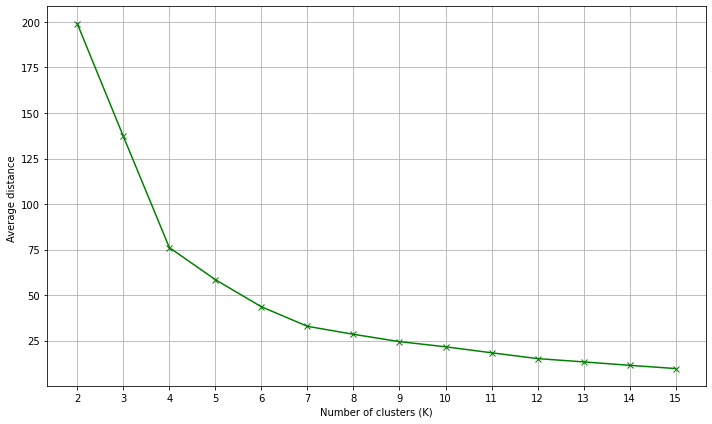

In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(range(2,Ks),inertia,'gx-')
plt.ylabel('Average distance ')
plt.xlabel('Number of clusters (K)')
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
#plt.scatter(8, inertia[7], marker='o', color='g', s=100)
#bbox_props = dict(boxstyle="larrow,pad=0.6", fc="white", ec="g", lw=2)
#t = ax.text(11, 20, "Elbow point (K = 8)", ha="center", va="center", rotation=37,
#            size=15,
#            bbox=bbox_props)
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
# set number of clusters
kclusters = 4

# run k-means clustering 
#kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(neighborhood_clustering)
kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(scaled_sales)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 2, 0, 0, 2, 2, 2, 0], dtype=int32)

In [49]:
df_cluster_shops.insert(0, 'shop_cluster', kmeans.labels_)
df_cluster_shops = df_cluster_shops[['shop_id', 'shop_cluster']].set_index('shop_id')
df_cluster_shops.head()

,shop_cluster
shop_id,
2,2
3,2
4,2
5,2
6,0


In [50]:
shop_clusters = {}

def get_shop_cluster(shop_id):
    if shop_id not in shop_clusters:
        shop_clusters[shop_id] = df_cluster_shops.loc[shop_id]['shop_cluster']
    return shop_clusters[shop_id]

### Cluster analysis for cities

In [51]:
#df_sales_items = df_sales.groupby(['date_block_num','shop_id'])['item_cnt_day'].sum().reset_index()
#df_sales_items['month'] = df_sales_items['date_block_num'] % 12 + 1
df_sales_items['city'] = df_sales_items['shop_id'].apply(lambda x: get_shop_city(x))
df_sales_items.head()

,date_block_num,shop_id,item_cnt_day,month,city
0,0,2,1151.00000,1,Адыгея
1,0,3,767.00000,1,Балашиха
2,0,4,2117.00000,1,Волжский
3,0,6,3699.00000,1,Воронеж
4,0,7,2498.00000,1,Воронеж


In [52]:
# for clustrer analysis
df_cluster_sales = df_sales_items.groupby(['month','city'])['item_cnt_day'].mean().to_frame(name='item_cnt_month').reset_index()
df_cluster_sales.head(10)

,month,city,item_cnt_month
0,1,Адыгея,1011.66667
1,1,Балашиха,906.66667
2,1,Волжский,1582.00000
3,1,Вологда,1525.00000
4,1,Воронеж,2498.00000
5,1,Жуковский,782.33333
6,1,Интернет,1622.66667
7,1,Казань,1318.80000
8,1,Калуга,2415.00000
9,1,Коломна,2202.33333


In [53]:
# for clustrer analysis
df_cluster_cities = df_cluster_sales.pivot_table(index=['city'], columns=['month'], values=['item_cnt_month'], fill_value=0)
df_cluster_cities.reset_index(inplace=True)
df_cluster_cities.columns = [ ''.join((name, str(date))) for (name, date) in df_cluster_cities.columns.values]
df_cluster_cities.head()

,city,item_cnt_month1,item_cnt_month2,item_cnt_month3,item_cnt_month4,item_cnt_month5,item_cnt_month6,item_cnt_month7,item_cnt_month8,item_cnt_month9,item_cnt_month10,item_cnt_month11,item_cnt_month12
0,Адыгея,1011.66667,772.66667,837.33333,749.00000,770.33333,865.66667,812.33333,925.66667,898.66667,823.66667,1028.00000,1624.50000
1,Балашиха,906.66667,806.00000,938.00000,693.33333,743.00000,764.33333,677.00000,821.66667,913.66667,740.66667,1020.00000,1211.00000
2,Волжский,1582.00000,1441.66667,1433.66667,782.00000,1144.66667,1159.00000,1108.00000,1351.66667,1121.66667,1167.66667,1431.00000,2165.50000
3,Вологда,1525.00000,1079.33333,1314.00000,1041.33333,1110.33333,1226.00000,1223.66667,1449.66667,1252.00000,1170.00000,1419.00000,2180.00000
4,Воронеж,2498.00000,2483.57143,2363.00000,2133.83333,1993.00000,2228.00000,2082.33333,2278.83333,2386.66667,2192.83333,2916.75000,4166.50000


In [54]:
#cluster analysis
from sklearn.preprocessing import StandardScaler
df_cluster_without_cities = df_cluster_cities.drop('city', axis=1)
scaled_sales = StandardScaler().fit_transform(df_cluster_without_cities.values)
scaled_sales.shape

(31, 12)

In [55]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

SEED = 579

#neighborhood_clustering = df_neighborhood_categories.drop('Neighborhood', axis=1)

# set number of clusters
Ks = 16
inertia = np.zeros((Ks-2))
for n in range(2,Ks):
    
    #Train Model and Predict  
    kmeans = KMeans(init='k-means++', n_clusters=n, random_state=SEED, algorithm="full").fit(scaled_sales)
    inertia[n-2] = kmeans.inertia_
inertia

array([155.88250852,  88.34965182,  53.01419296,  31.20142773,
        18.31006879,  13.2898509 ,  10.20547917,   8.13279621,
         6.50231132,   5.25154494,   4.24848096,   3.39416377,
         2.95094557,   2.49360133])

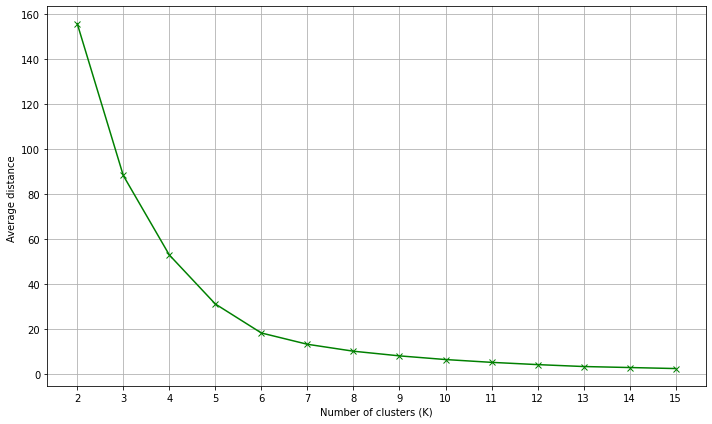

In [56]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(range(2,Ks),inertia,'gx-')
plt.ylabel('Average distance ')
plt.xlabel('Number of clusters (K)')
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
#plt.scatter(8, inertia[7], marker='o', color='g', s=100)
#bbox_props = dict(boxstyle="larrow,pad=0.6", fc="white", ec="g", lw=2)
#t = ax.text(11, 20, "Elbow point (K = 8)", ha="center", va="center", rotation=37,
#            size=15,
#            bbox=bbox_props)
plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
# set number of clusters
kclusters = 6

# run k-means clustering 
#kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(neighborhood_clustering)
kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(scaled_sales)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 1, 1, 4, 5, 3, 4, 1, 4], dtype=int32)

In [58]:
df_cluster_cities.insert(0, 'city_cluster', kmeans.labels_)
df_cluster_cities = df_cluster_cities[['city', 'city_cluster']].set_index('city')
df_cluster_cities.head(10)

,city_cluster
city,
Адыгея,3
Балашиха,3
Волжский,1
Вологда,1
Воронеж,4
Выездная,5
Жуковский,3
Интернет,4
Казань,1


In [59]:
city_clusters = {}

def get_city_cluster(city):
    if city not in city_clusters:
        city_clusters[city] = df_cluster_cities.loc[city]['city_cluster']
    return city_clusters[city]

## Cluster analysis for categories

In [60]:
df_sales_items = df_sales.groupby(['date_block_num','shop_id', 'category'])['item_cnt_day'].sum().reset_index()
df_sales_items['month'] = df_sales_items['date_block_num'] % 12 + 1
df_sales_items.head()

,date_block_num,shop_id,category,item_cnt_day,month
0,0,2,Аксессуары - PS3,26.00000,1
1,0,2,Аксессуары - PS4,9.00000,1
2,0,2,Аксессуары - PSP,10.00000,1
3,0,2,Аксессуары - PSVita,10.00000,1
4,0,2,Аксессуары - XBOX 360,12.00000,1


In [61]:
# for clustrer analysis
df_cluster_sales = df_sales.groupby(['month','category'])['item_cnt_day'].mean().to_frame(name='item_cnt_month').reset_index()
df_cluster_sales.head(10)

,month,category,item_cnt_month
0,1,PC - Гарнитуры/Наушники,1.00000
1,1,Аксессуары - PS2,1.00000
2,1,Аксессуары - PS3,2.36758
3,1,Аксессуары - PS4,3.61383
4,1,Аксессуары - PSP,1.90000
5,1,Аксессуары - PSVita,1.70063
6,1,Аксессуары - XBOX 360,2.95439
7,1,Аксессуары - XBOX ONE,2.52140
8,1,Доставка товара,48.37500
9,1,Игровые консоли - PS3,2.22402


In [62]:
# for clustrer analysis
df_cluster_categories = df_cluster_sales.pivot_table(index=['category'], columns=['month'], values=['item_cnt_month'], fill_value=0)
df_cluster_categories.reset_index(inplace=True)
df_cluster_categories.columns = [ ''.join((name, str(date))) for (name, date) in df_cluster_categories.columns.values]
df_cluster_categories.head()

,category,item_cnt_month1,item_cnt_month2,item_cnt_month3,item_cnt_month4,item_cnt_month5,item_cnt_month6,item_cnt_month7,item_cnt_month8,item_cnt_month9,item_cnt_month10,item_cnt_month11,item_cnt_month12
0,PC - Гарнитуры/Наушники,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,Аксессуары - PS2,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,Аксессуары - PS3,2.36758,1.98415,1.79925,1.57429,1.52564,1.54590,1.54688,1.59066,1.55583,1.58081,1.73758,2.86186
3,Аксессуары - PS4,3.61383,3.86819,2.97715,2.57711,2.39782,2.51763,2.65944,2.73947,3.02183,2.82424,3.10231,5.37353
4,Аксессуары - PSP,1.90000,1.86806,1.87582,1.64167,1.53472,1.75758,1.85246,1.87368,1.66154,1.58904,1.89796,1.65000


In [63]:
#cluster analysis
from sklearn.preprocessing import StandardScaler
df_cluster_without_categories = df_cluster_categories.drop('category', axis=1)
scaled_sales = StandardScaler().fit_transform(df_cluster_without_categories.values)
scaled_sales.shape

(84, 12)

In [64]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

SEED = 579

#neighborhood_clustering = df_neighborhood_categories.drop('Neighborhood', axis=1)

# set number of clusters
Ks = 16
inertia = np.zeros((Ks-2))
for n in range(2,Ks):
    
    #Train Model and Predict  
    kmeans = KMeans(init='k-means++', n_clusters=n, random_state=SEED, algorithm="full").fit(scaled_sales)
    inertia[n-2] = kmeans.inertia_
inertia

array([172.47797851,  86.92885838,  45.18085997,  17.86571179,
         9.56680138,   6.3897664 ,   3.90754301,   3.06815561,
         2.51670237,   2.02559259,   1.64644154,   1.27731507,
         0.97499143,   0.83807293])

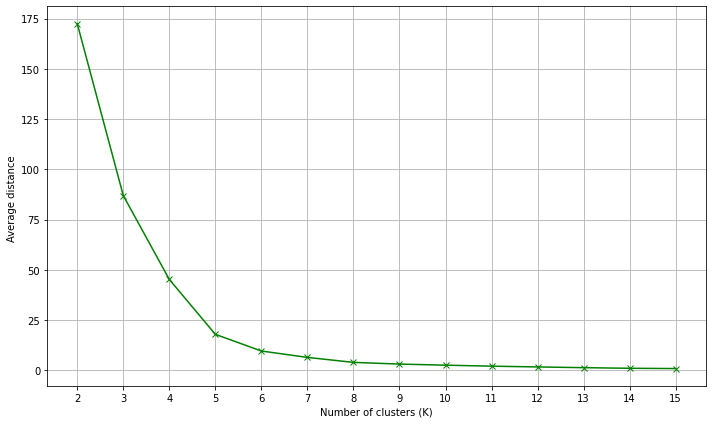

In [65]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(range(2,Ks),inertia,'gx-')
plt.ylabel('Average distance ')
plt.xlabel('Number of clusters (K)')
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
#plt.scatter(8, inertia[7], marker='o', color='g', s=100)
#bbox_props = dict(boxstyle="larrow,pad=0.6", fc="white", ec="g", lw=2)
#t = ax.text(11, 20, "Elbow point (K = 8)", ha="center", va="center", rotation=37,
#            size=15,
#            bbox=bbox_props)
plt.grid(True)
plt.tight_layout()
plt.show()

In [66]:
# set number of clusters
kclusters = 5

# run k-means clustering 
#kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(neighborhood_clustering)
kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(scaled_sales)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 4, 3], dtype=int32)

In [67]:
df_cluster_categories.insert(0, 'category_cluster', kmeans.labels_)
df_cluster_categories = df_cluster_categories[['category', 'category_cluster']].set_index('category')
df_cluster_categories.head()

,category_cluster
category,
PC - Гарнитуры/Наушники,0
Аксессуары - PS2,0
Аксессуары - PS3,0
Аксессуары - PS4,0
Аксессуары - PSP,0


In [68]:
category_clusters = {}

def get_category_cluster(category):
    if category not in category_clusters:
        category_clusters[category] = df_cluster_categories.loc[category]['category_cluster']
    return category_clusters[category]

## Model

In [69]:
#df_monthly_sales = df_sales.groupby(['date_block_num','shop_id','item_id'])[['item_cnt_day', 'revenue']].sum().reset_index()#.to_frame(name='item_cnt_month').reset_index()
#df_monthly_sales = df_sales.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].sum().to_frame(name='item_cnt_month').reset_index()
df_monthly_sales = df_sales.copy()
df_monthly_sales.head(10)

,date_block_num,shop_id,item_id,item_cnt_day,revenue,item_price,shop_type,category,city,month
0,0,2,27,1.00000,2499.00000,2499.00000,ТЦ,Игры - PS3,Адыгея,1
1,0,2,33,1.00000,499.00000,499.00000,ТЦ,Кино - Blu-Ray,Адыгея,1
2,0,2,317,1.00000,299.00000,299.00000,ТЦ,Книги - Аудиокниги 1С,Адыгея,1
3,0,2,438,1.00000,299.00000,299.00000,ТЦ,Книги - Аудиокниги 1С,Адыгея,1
4,0,2,471,2.00000,798.00000,399.00000,ТЦ,Книги - Методические материалы 1С,Адыгея,1
5,0,2,481,1.00000,330.00000,330.00000,ТЦ,Книги - Методические материалы 1С,Адыгея,1
6,0,2,482,1.00000,3300.00000,3300.00000,ТЦ,Программы - 1С:Предприятие 8,Адыгея,1
7,0,2,484,2.00000,600.00000,300.00000,ТЦ,Программы - 1С:Предприятие 8,Адыгея,1
8,0,2,491,1.00000,600.00000,600.00000,ТЦ,Программы - 1С:Предприятие 8,Адыгея,1
9,0,2,534,2.00000,798.00000,399.00000,ТЦ,Программы - Обучающие,Адыгея,1


In [70]:
df_monthly_sales.loc[(df_monthly_sales['date_block_num']==0) & (df_monthly_sales['item_id'] == 2552) & (df_monthly_sales['shop_id'] == 25)]

,date_block_num,shop_id,item_id,item_cnt_day,revenue,item_price,shop_type,category,city,month
19521,0,25,2552,1.00000,899.00000,899.00000,ТРК,Музыка - Винил,Москва,1


In [71]:
# clip all cnt
df_monthly_sales['item_cnt_day'] = np.clip(df_monthly_sales['item_cnt_day'], 0, 20)

In [72]:
df_monthly_sales.describe()

,date_block_num,shop_id,item_id,item_cnt_day,revenue,item_price,month
count,1607374.00000,1607374.00000,1607374.00000,1607374.00000,1607374.00000,1607374.00000,1607374.00000
mean,14.66230,33.09043,10681.30604,2.02878,2121.38310,789.98726,6.15428
std,9.54389,16.46960,6238.68984,2.58019,15334.45559,1549.52683,3.45495
min,0.00000,2.00000,0.00000,1.00000,0.09000,0.09000,1.00000
25%,6.00000,21.00000,5046.00000,1.00000,249.00000,199.00000,3.00000
50%,14.00000,31.00000,10497.00000,1.00000,549.00000,399.00000,6.00000
75%,23.00000,48.00000,16060.00000,2.00000,1494.00000,890.00000,9.00000
max,33.00000,59.00000,22169.00000,20.00000,6264230.00000,307980.00000,12.00000


In [73]:
df = df_monthly_sales.pivot_table(index=['shop_id','item_id'], columns=['date_block_num'], values='item_cnt_day', fill_value=0)
#df = df_monthly_sales.pivot_table(index=['shop_id','item_id'], columns=['date_block_num'], values=['item_cnt_day', 'item_price'], fill_value=0)
df.reset_index(inplace=True)
df.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,27,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,30,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,31,0,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,32,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,2,33,1,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0


In [74]:
#df.columns = [ ''.join((name, str(date))) for (name, date) in df.columns.values]
#df['item_cnt_day34'] = np.nan
#df['revenue34'] = np.nan
df[34] = np.nan
df.describe()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,34
count,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,...,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,0.00000
mean,31.96346,11458.04824,0.30385,0.29209,0.32531,0.24716,0.23835,0.26450,0.25638,0.27428,...,0.18969,0.18410,0.14980,0.14455,0.14199,0.14216,0.14798,0.13819,0.14754,NaN
std,16.70213,6133.60013,1.21014,1.22206,1.33966,1.05987,1.02628,1.12942,1.04241,1.12800,...,0.90324,0.89312,0.86643,0.82067,0.78811,0.74499,0.77524,0.84578,0.86760,NaN
min,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,NaN
25%,18.00000,6246.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,NaN
50%,30.00000,11614.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,NaN
75%,47.00000,16662.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,NaN
max,59.00000,22169.00000,20.00000,20.00000,20.00000,20.00000,20.00000,20.00000,20.00000,20.00000,...,20.00000,20.00000,20.00000,20.00000,20.00000,20.00000,20.00000,20.00000,20.00000,NaN


In [75]:
#df_test = pd.merge(df_test, df, on=['shop_id','item_id'], how='left')
#df_test = df_test.fillna(0)
#df_test.drop(['ID'], axis=1, inplace=True)
#df_test.head()

In [76]:
# calc prev month
df['prev0'] = np.nan
df['prev_diff0'] = np.nan
df['mean3_0'] = np.nan
df['mean6_0'] = np.nan
#df_test['prev_year0'] = np.nan
#df_test['revenue_prev0'] = np.nan
#df_test['revenue_prev_diff0'] = np.nan
#df_test['revenue_prev_year0'] = np.nan
for col in range(1, 35):
    df[''.join(('prev', str(col)))] = df[col-1]
    df[''.join(('prev_diff', str(col)))] = df[''.join(('prev', str(col)))] - df[''.join(('prev', str(col-1)))]
    df[''.join(('mean3_', str(col)))] = np.nan

    if col > 2:
        df[''.join(('mean3_', str(col)))] = (df[col-1] + df[col-2] + df[col-3])/3
        
    df[''.join(('mean6_', str(col)))] = np.nan
    if col > 5:
        df[''.join(('mean6_', str(col)))] = (df[col-1] + df[col-2] + df[col-3] + df[col-4] + df[col-5] + df[col-6])/6
        
#    df_test[''.join(('revenue_prev_year', str(col)))] = np.nan
#    df_test[''.join(('prev_year', str(col)))] = np.nan
#    if col > 11:
#        df_test[''.join(('prev_year', str(col)))] = df_test[col-12]
#        df_test[''.join(('revenue_prev_year', str(col)))] = df_test[''.join(('revenue', str(col-12)))]
#    df_test[''.join(('revenue_prev', str(col)))] = df_test[''.join(('revenue', str(col-1)))]
#    df_test[''.join(('revenue_prev_diff', str(col)))] = df_test[''.join(('revenue_prev', str(col)))] - df_test[''.join(('revenue_prev', str(col-1)))]
        
df.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,mean3_32,mean6_32,prev33,prev_diff33,mean3_33,mean6_33,prev34,prev_diff34,mean3_34,mean6_34
0,2,27,1,0,0,0,0,0,0,0,...,0.00000,0.00000,0,0,0.00000,0.00000,0,0,0.00000,0.00000
1,2,30,0,0,1,0,0,1,0,0,...,0.00000,0.00000,0,0,0.00000,0.00000,0,0,0.00000,0.00000
2,2,31,0,4,1,1,0,0,0,0,...,0.00000,0.00000,0,0,0.00000,0.00000,1,1,0.33333,0.16667
3,2,32,0,0,0,0,0,0,0,0,...,0.33333,0.33333,0,-1,0.33333,0.16667,0,0,0.33333,0.16667
4,2,33,1,0,0,0,0,0,0,0,...,0.33333,0.50000,1,1,0.66667,0.66667,0,-1,0.33333,0.50000


In [77]:
# calc quarts
for col in range(2, 35):
    if (col+1)%3 == 0:
        q = (col+1)//3
        df[''.join(('Q', str(q)))] = df[col] + df[col-1] + df[col-2]
        #df_test[''.join(('revenueQ', str(q)))] = df_test[''.join(('revenue', str(col)))] + df_test[''.join(('revenue', str(col-1)))] + df_test[''.join(('revenue', str(col-2)))]
df.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11
0,2,27,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2,30,0,0,1,0,0,1,0,0,...,1,0,0,0,2,0,0,0,0,0
2,2,31,0,4,1,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,2,32,0,0,0,0,0,0,0,0,...,0,0,0,2,0,3,4,1,0,1
4,2,33,1,0,0,0,0,0,0,0,...,0,0,3,1,0,1,0,1,2,2


In [78]:
#df_test[[''.join(('itemQ', str(q))) for q in range(1,12)]].describe()
df[[''.join(('prev_diff', str(q))) for q in range(35)]].describe()

date_block_num,prev_diff0,prev_diff1,prev_diff2,prev_diff3,prev_diff4,prev_diff5,prev_diff6,prev_diff7,prev_diff8,prev_diff9,...,prev_diff25,prev_diff26,prev_diff27,prev_diff28,prev_diff29,prev_diff30,prev_diff31,prev_diff32,prev_diff33,prev_diff34
count,0.00000,0.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,...,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000
mean,NaN,NaN,-0.01176,0.03322,-0.07816,-0.00881,0.02615,-0.00812,0.01790,-0.01270,...,-0.11753,-0.04392,-0.00559,-0.03430,-0.00525,-0.00255,0.00016,0.00582,-0.00979,0.00935
std,NaN,NaN,1.12120,1.24573,1.14111,0.98120,1.02639,0.95159,0.99995,1.15133,...,1.05577,0.89919,0.80950,0.88506,0.82237,0.72283,0.66468,0.70077,0.77330,0.89133
min,NaN,NaN,-20.00000,-20.00000,-20.00000,-20.00000,-20.00000,-20.00000,-20.00000,-20.00000,...,-20.00000,-20.00000,-20.00000,-20.00000,-20.00000,-20.00000,-20.00000,-20.00000,-20.00000,-20.00000
25%,NaN,NaN,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,NaN,NaN,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,NaN,NaN,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
max,NaN,NaN,20.00000,20.00000,20.00000,20.00000,20.00000,20.00000,20.00000,20.00000,...,20.00000,20.00000,20.00000,20.00000,20.00000,20.00000,20.00000,20.00000,20.00000,20.00000


In [79]:
df.columns.values

array(['shop_id', 'item_id', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 'prev0', 'prev_diff0', 'mean3_0', 'mean6_0',
       'prev1', 'prev_diff1', 'mean3_1', 'mean6_1', 'prev2', 'prev_diff2',
       'mean3_2', 'mean6_2', 'prev3', 'prev_diff3', 'mean3_3', 'mean6_3',
       'prev4', 'prev_diff4', 'mean3_4', 'mean6_4', 'prev5', 'prev_diff5',
       'mean3_5', 'mean6_5', 'prev6', 'prev_diff6', 'mean3_6', 'mean6_6',
       'prev7', 'prev_diff7', 'mean3_7', 'mean6_7', 'prev8', 'prev_diff8',
       'mean3_8', 'mean6_8', 'prev9', 'prev_diff9', 'mean3_9', 'mean6_9',
       'prev10', 'prev_diff10', 'mean3_10', 'mean6_10', 'prev11',
       'prev_diff11', 'mean3_11', 'mean6_11', 'prev12', 'prev_diff12',
       'mean3_12', 'mean6_12', 'prev13', 'prev_diff13', 'mean3_13',
       'mean6_13', 'prev14', 'prev_diff14', 'mean3_14', 'mean6_14',
       'prev15', 'prev_diff15', 'mean3_15', 'mean6_15', 'prev1

In [80]:
df.describe()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11
count,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,...,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000,418200.00000
mean,31.96346,11458.04824,0.30385,0.29209,0.32531,0.24716,0.23835,0.26450,0.25638,0.27428,...,0.75000,0.79223,0.90549,0.74740,0.62838,0.62548,0.80788,0.60741,0.43634,0.42833
std,16.70213,6133.60013,1.21014,1.22206,1.33966,1.05987,1.02628,1.12942,1.04241,1.12800,...,2.62175,2.76709,3.29952,2.81856,2.49076,2.49272,3.07890,2.41946,2.04391,1.93905
min,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,18.00000,6246.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,30.00000,11614.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,47.00000,16662.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
max,59.00000,22169.00000,20.00000,20.00000,20.00000,20.00000,20.00000,20.00000,20.00000,20.00000,...,60.00000,60.00000,60.00000,60.00000,60.00000,60.00000,60.00000,60.00000,60.00000,60.00000


In [81]:
#df_test = pd.merge(df_test, df, on=['shop_id','item_id'], how='left')
#df_test = df_test.fillna(0)
#df_test.drop(['ID'], axis=1, inplace=True)
#df_test.head()

In [82]:
df_sells_in_month = pd.melt(df, id_vars=['shop_id', 'item_id'], value_vars=[i for i in range(35)], var_name='date_block_num', value_name='item_cnt_month')
df_sells_in_month.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,2,27,0,1.00000
1,2,30,0,0.00000
2,2,31,0,0.00000
3,2,32,0,0.00000
4,2,33,0,1.00000


In [83]:
df_sells_in_prev_month = pd.melt(df, id_vars=['shop_id', 'item_id'], value_vars=[''.join(('prev', str(i))) for i in range(35)], var_name='date_block_num', value_name='prev_month')
df_sells_in_prev_month.tail()

,shop_id,item_id,date_block_num,prev_month
14636995,59,22154,prev34,0.00000
14636996,59,22155,prev34,0.00000
14636997,59,22162,prev34,0.00000
14636998,59,22164,prev34,0.00000
14636999,59,22167,prev34,0.00000


In [84]:
df_sells_diff_in_month = pd.melt(df, id_vars=['shop_id', 'item_id'], value_vars=[''.join(('prev_diff', str(i))) for i in range(35)], var_name='date_block_num', value_name='prev_diff')
df_sells_diff_in_month.tail()

,shop_id,item_id,date_block_num,prev_diff
14636995,59,22154,prev_diff34,0.00000
14636996,59,22155,prev_diff34,0.00000
14636997,59,22162,prev_diff34,0.00000
14636998,59,22164,prev_diff34,0.00000
14636999,59,22167,prev_diff34,0.00000


In [85]:
df_sells_mean3 = pd.melt(df, id_vars=['shop_id', 'item_id'], value_vars=[''.join(('mean3_', str(i))) for i in range(35)], var_name='date_block_num', value_name='mean3')
df_sells_mean3.tail()

,shop_id,item_id,date_block_num,mean3
14636995,59,22154,mean3_34,0.00000
14636996,59,22155,mean3_34,0.00000
14636997,59,22162,mean3_34,0.33333
14636998,59,22164,mean3_34,0.00000
14636999,59,22167,mean3_34,0.00000


In [86]:
df_sells_mean6 = pd.melt(df, id_vars=['shop_id', 'item_id'], value_vars=[''.join(('mean6_', str(i))) for i in range(35)], var_name='date_block_num', value_name='mean6')
df_sells_mean6.tail()

,shop_id,item_id,date_block_num,mean6
14636995,59,22154,mean6_34,0.00000
14636996,59,22155,mean6_34,0.00000
14636997,59,22162,mean6_34,0.33333
14636998,59,22164,mean6_34,0.16667
14636999,59,22167,mean6_34,0.00000


In [87]:
#df_sells_prev_year = pd.melt(df_test, id_vars=['shop_id', 'item_id'], value_vars=[''.join(('item_cnt_day_prev_year', str(i))) for i in range(35)], var_name='date_block_num', value_name='item_cnt_prev_year')
#df_sells_prev_year.tail()

In [88]:
#df_revenue_in_month = pd.melt(df_test, id_vars=['shop_id', 'item_id'], value_vars=[''.join(('revenue', str(i))) for i in range(35)], var_name='date_block_num', value_name='revenue')
#df_revenue_in_month.tail()

In [89]:
#df_revenue_in_prev_month = pd.melt(df_test, id_vars=['shop_id', 'item_id'], value_vars=[''.join(('revenue_prev', str(i))) for i in range(35)], var_name='date_block_num', value_name='revenue_prev')
#df_revenue_in_prev_month.tail()

In [90]:
#df_revenue_diff_in_month = pd.melt(df_test, id_vars=['shop_id', 'item_id'], value_vars=[''.join(('revenue_prev_diff', str(i))) for i in range(35)], var_name='date_block_num', value_name='revenue_prev_diff')
#df_revenue_diff_in_month.tail()

In [91]:
#df_revenue_prev_year = pd.melt(df_test, id_vars=['shop_id', 'item_id'], value_vars=[''.join(('revenue_prev_year', str(i))) for i in range(35)], var_name='date_block_num', value_name='revenue_prev_year')
#df_revenue_prev_year.tail()

In [92]:
df_sells_in_month['prev_month'] = df_sells_in_prev_month['prev_month']
df_sells_in_month['prev_diff'] = df_sells_diff_in_month['prev_diff']
df_sells_in_month['mean3'] = df_sells_mean3['mean3']
df_sells_in_month['mean6'] = df_sells_mean6['mean6']
#df_sells_in_month['item_cnt_prev_year'] = df_sells_prev_year['item_cnt_prev_year']
#df_sells_in_month['revenue'] = df_revenue_in_month['revenue']
#df_sells_in_month['revenue_prev'] = df_revenue_in_prev_month['revenue_prev']
#df_sells_in_month['revenue_prev_diff'] = df_revenue_diff_in_month['revenue_prev_diff']
#df_sells_in_month['revenue_prev_year'] = df_revenue_prev_year['revenue_prev_year']
#df_sells_in_month['date_block_num'] = df_sells_in_month['date_block_num'].apply(lambda x: int(x.replace('item_cnt_day','')))
df_sells_in_month.head()

,shop_id,item_id,date_block_num,item_cnt_month,prev_month,prev_diff,mean3,mean6
0,2,27,0,1.00000,NaN,NaN,NaN,NaN
1,2,30,0,0.00000,NaN,NaN,NaN,NaN
2,2,31,0,0.00000,NaN,NaN,NaN,NaN
3,2,32,0,0.00000,NaN,NaN,NaN,NaN
4,2,33,0,1.00000,NaN,NaN,NaN,NaN


In [93]:
df_sells_in_month['prev_itemQ'] = np.nan
#df_sells_in_month['prev_revenueQ'] = np.nan
# calc quarts
for month in range(3, 35):
    q = (month)//3
#    print(''.join(('Q', str(q))))
    df_sells_in_month.loc[df_sells_in_month['date_block_num'] == month, 'prev_itemQ'] = df[''.join(('Q', str(q)))].values
#    df_sells_in_month.loc[df_sells_in_month['date_block_num'] == month, 'prev_revenueQ'] = df_test[''.join(('revenueQ', str(q)))].values
df_sells_in_month.head()

,shop_id,item_id,date_block_num,item_cnt_month,prev_month,prev_diff,mean3,mean6,prev_itemQ
0,2,27,0,1.00000,NaN,NaN,NaN,NaN,NaN
1,2,30,0,0.00000,NaN,NaN,NaN,NaN,NaN
2,2,31,0,0.00000,NaN,NaN,NaN,NaN,NaN
3,2,32,0,0.00000,NaN,NaN,NaN,NaN,NaN
4,2,33,0,1.00000,NaN,NaN,NaN,NaN,NaN


In [94]:
# 45,18454
#df_sells_in_month.tail()
df_sells_in_month.loc[(df_sells_in_month['shop_id'] == 45) & (df_sells_in_month['item_id'] == 18454)]
#df_test.loc[(df_test['shop_id'] == 45) & (df_test['item_id'] == 18454)]
#len(df_test['Q1'].values)
#len(df_sells_in_month[df_sells_in_month['date_block_num'] == month,['prev_q']].values)

,shop_id,item_id,date_block_num,item_cnt_month,prev_month,prev_diff,mean3,mean6,prev_itemQ
302156,45,18454,0,0.00000,NaN,NaN,NaN,NaN,NaN
720356,45,18454,1,0.00000,0.00000,NaN,NaN,NaN,NaN
1138556,45,18454,2,0.00000,0.00000,0.00000,NaN,NaN,NaN
1556756,45,18454,3,0.00000,0.00000,0.00000,0.00000,NaN,0.00000
1974956,45,18454,4,0.00000,0.00000,0.00000,0.00000,NaN,0.00000
2393156,45,18454,5,0.00000,0.00000,0.00000,0.00000,NaN,0.00000
2811356,45,18454,6,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3229556,45,18454,7,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3647756,45,18454,8,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4065956,45,18454,9,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [95]:
print("Shape with zeros - ", df_sells_in_month.shape)
df_sells_in_month_34 = df_sells_in_month.loc[df_sells_in_month['date_block_num'] == 34].copy()
df_sells_in_month = df_sells_in_month.loc[df_sells_in_month['item_cnt_month'] > 0]
print("Shape without zeros - ", df_sells_in_month.shape)

Shape with zeros -  (14637000, 9)
Shape without zeros -  (1607374, 9)


In [96]:
%%time
df_sells_in_month['shop_type'] = df_sells_in_month['shop_id'].apply(lambda x: get_shop_type(x))
df_sells_in_month_34['shop_type'] = df_sells_in_month_34['shop_id'].apply(lambda x: get_shop_type(x))

CPU times: user 1.16 s, sys: 18.5 ms, total: 1.18 s
Wall time: 1.27 s


In [97]:
%%time
df_sells_in_month['shop_mega'] = df_sells_in_month['shop_id'].apply(lambda x: get_shop_megality(x))
df_sells_in_month_34['shop_mega'] = df_sells_in_month_34['shop_id'].apply(lambda x: get_shop_megality(x))

CPU times: user 2.12 s, sys: 42.9 ms, total: 2.16 s
Wall time: 2.18 s


In [98]:
%%time
df_sells_in_month['shop_cluster'] = df_sells_in_month['shop_id'].apply(lambda x: get_shop_cluster(x))
df_sells_in_month_34['shop_cluster'] = df_sells_in_month_34['shop_id'].apply(lambda x: get_shop_cluster(x))

CPU times: user 2.09 s, sys: 57 ms, total: 2.15 s
Wall time: 2.17 s


In [99]:
%%time
df_sells_in_month['subcategory'] = df_sells_in_month['item_id'].apply(lambda x: get_category(x))
df_sells_in_month_34['subcategory'] = df_sells_in_month_34['item_id'].apply(lambda x: get_category(x))

CPU times: user 2.73 s, sys: 166 ms, total: 2.9 s
Wall time: 3.14 s


In [100]:
%%time
df_sells_in_month['digital'] = df_sells_in_month['item_id'].apply(lambda x: get_category_digitality(x))
df_sells_in_month_34['digital'] = df_sells_in_month_34['item_id'].apply(lambda x: get_category_digitality(x))

CPU times: user 3.61 s, sys: 113 ms, total: 3.73 s
Wall time: 3.76 s


In [101]:
%%time
df_sells_in_month['city'] = df_sells_in_month['shop_id'].apply(lambda x: get_shop_city(x))
df_sells_in_month_34['city'] = df_sells_in_month_34['shop_id'].apply(lambda x: get_shop_city(x))

CPU times: user 1.16 s, sys: 7.61 ms, total: 1.16 s
Wall time: 1.18 s


In [102]:
%%time
df_sells_in_month['city_cluster'] = df_sells_in_month['city'].apply(lambda x: get_city_cluster(x))
df_sells_in_month_34['city_cluster'] = df_sells_in_month_34['city'].apply(lambda x: get_city_cluster(x))

CPU times: user 2.07 s, sys: 41.5 ms, total: 2.11 s
Wall time: 2.14 s


In [103]:
%%time
df_sells_in_month['category_cluster'] = df_sells_in_month['subcategory'].apply(lambda x: get_category_cluster(x))
df_sells_in_month_34['category_cluster'] = df_sells_in_month_34['subcategory'].apply(lambda x: get_category_cluster(x))

CPU times: user 2.05 s, sys: 38.5 ms, total: 2.09 s
Wall time: 2.13 s


In [104]:
%%time
df_sells_in_month['category'] = df_sells_in_month['subcategory'].str.split('[-(]', n=0).str[0].str.strip()
df_sells_in_month_34['category'] = df_sells_in_month_34['subcategory'].str.split('[-(]', n=0).str[0].str.strip()

CPU times: user 15.2 s, sys: 1.62 s, total: 16.9 s
Wall time: 19.2 s


In [105]:
%%time
df_sells_in_month['month'] = df_sells_in_month['date_block_num']%12 + 1
df_sells_in_month_34['month'] = df_sells_in_month_34['date_block_num']%12 + 1

CPU times: user 355 ms, sys: 3.71 ms, total: 358 ms
Wall time: 359 ms


In [106]:
%%time
df_sells_in_month[item_labels.columns.values] = df_sells_in_month['item_id'].apply(lambda x: get_items_features(x))
df_sells_in_month_34[item_labels.columns.values] = df_sells_in_month_34['item_id'].apply(lambda x: get_items_features(x))

CPU times: user 4min 26s, sys: 34.1 s, total: 5min
Wall time: 4min 22s


In [107]:
%%time
df_sells_in_month['holydays'] = df_sells_in_month['date_block_num'].apply(lambda x: get_holydays(x))
df_sells_in_month_34['holydays'] = df_sells_in_month_34['date_block_num'].apply(lambda x: get_holydays(x))

CPU times: user 1.84 s, sys: 43.1 ms, total: 1.88 s
Wall time: 1.88 s


In [108]:
%%time
df_sells_in_month['weekends'] = df_sells_in_month['date_block_num'].apply(lambda x: get_weekends(x))
df_sells_in_month_34['weekends'] = df_sells_in_month_34['date_block_num'].apply(lambda x: get_weekends(x))

CPU times: user 1.86 s, sys: 37.1 ms, total: 1.89 s
Wall time: 1.9 s


In [109]:
%%time
df_sells_in_month['prev_item_price'] = df_sells_in_month.apply(lambda x: get_item_price(x['date_block_num']-1, x['item_id']), axis=1)
df_sells_in_month_34['prev_item_price'] = df_sells_in_month_34.apply(lambda x: get_item_price(x['date_block_num']-1, x['item_id']), axis=1)

CPU times: user 1min 11s, sys: 3.95 s, total: 1min 14s
Wall time: 1min 23s


In [110]:
%%time
df_sells_in_month['prev_shop_price'] = df_sells_in_month.apply(lambda x: get_shop_price(x['date_block_num']-1, x['shop_id'], x['item_id']), axis=1)
df_sells_in_month_34['prev_shop_price'] = df_sells_in_month_34.apply(lambda x: get_shop_price(x['date_block_num']-1, x['shop_id'], x['item_id']), axis=1)

CPU times: user 1min 28s, sys: 1.76 s, total: 1min 29s
Wall time: 1min 32s


In [111]:
# clip all
#df_sells_in_month['item_cnt_prev_month'] = np.clip(df_sells_in_month['item_cnt_prev_month'], 0, 20)
#df_sells_in_month['item_cnt_month'] = np.clip(df_sells_in_month['item_cnt_month'], 0, 20)
df_sells_in_month['prev_itemQ'].describe()

count   1420342.00000
mean          3.34869
std           6.60518
min           0.00000
25%           0.00000
50%           1.00000
75%           4.00000
max          60.00000
Name: prev_itemQ, dtype: float64

In [112]:
df_sells_in_month.tail()

,shop_id,item_id,date_block_num,item_cnt_month,prev_month,prev_diff,mean3,mean6,prev_itemQ,shop_type,...,l0_русские субтитры,l0_essentials,l0_psp,l0_русская документация,l0_ps4,l0_xbox one,holydays,weekends,prev_item_price,prev_shop_price
14218771,59,22087,33,6.00000,3.00000,1.00000,3.33333,2.50000,10.00000,ТЦ,...,0,0,0,0,0,0,0,9,117.04680,119.00000
14218772,59,22088,33,2.00000,1.00000,-6.00000,5.00000,4.16667,15.00000,ТЦ,...,0,0,0,0,0,0,0,9,117.32353,119.00000
14218773,59,22091,33,1.00000,3.00000,3.00000,1.00000,0.50000,3.00000,ТЦ,...,0,0,0,0,0,0,0,9,178.14286,179.00000
14218775,59,22100,33,1.00000,1.00000,1.00000,0.33333,0.16667,1.00000,ТЦ,...,0,0,0,0,0,0,0,9,620.58065,629.00000
14218776,59,22102,33,1.00000,0.00000,-2.00000,0.66667,0.50000,2.00000,ТЦ,...,0,0,0,0,0,0,0,9,1244.62857,0.00000


In [113]:
df_sells_in_month.columns.values

array(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month',
       'prev_month', 'prev_diff', 'mean3', 'mean6', 'prev_itemQ',
       'shop_type', 'shop_mega', 'shop_cluster', 'subcategory', 'digital',
       'city', 'city_cluster', 'category_cluster', 'category', 'month',
       'l0_pc', 'l0_цифровая версия', 'l0_регион', 'l0_ps3',
       'l0_русская версия', 'l0_jewel', 'l0_xbox 360', 'l0_bd', 'l0_rem',
       'l0_cd', 'l0_digipack', 'l0_mp3', 'l0_dvd', 'l0_box',
       'l0_английская версия', 'l0_фирм', 'l0_3d', 'l0_русские субтитры',
       'l0_essentials', 'l0_psp', 'l0_русская документация', 'l0_ps4',
       'l0_xbox one', 'holydays', 'weekends', 'prev_item_price',
       'prev_shop_price'], dtype=object)

In [114]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score

date_ix = 0

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes_names):
        self.attributes_names = attributes_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attributes_names].values # convert to NumPy array

class CycleTransformator( BaseEstimator, TransformerMixin):
    #Class Constructor 
    def __init__( self,  cycle_columns ):
        self._cycle_columns = cycle_columns
        self._cycle_stats = {}
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        for column in self._cycle_columns:
            self._cycle_stats[column] = { 'max': X[column].max(), 'min': X[column].min() }
        return self
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        self._df = pd.DataFrame(index=X.index)
        for column in self._cycle_columns:
            self._df[column+'_sin'] = np.sin(2*np.pi/(self._cycle_stats[column]['max']+1)*X[column].fillna(self._cycle_stats[column]['min']-1))
            self._df[column+'_cos'] = np.cos(2*np.pi/(self._cycle_stats[column]['max']+1)*X[column].fillna(self._cycle_stats[column]['min']-1))

        #self._df = self._df.reset_index(drop=True)
        #print('Cycle transform shape is {}'.format(self._df.values.shape))
        return self._df.values

In [115]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [116]:
from sklearn.metrics import make_scorer

def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

In [117]:
#num_attribs = ['item_cnt_prev_month','item_cnt_prev_diff','prev_itemQ','item_cnt_prev_year']
num_attribs = ['prev_month','prev_diff', 'prev_itemQ', 'mean3', 'mean6', 'weekends', 'holydays', 'prev_item_price', 'prev_shop_price']
l12_cols = item_labels.columns.values
#num_attribs = np.concatenate([num_attribs,l12_cols])
#num_attribs = ['digital']
#cat_attribs = ['shop_cluster', 'category_cluster']
cat_attribs = ['city_cluster','shop_cluster', 'category_cluster']
#cat_attribs = ['city_cluster','shop_cluster', 'category_cluster', 'shop_type', 'subcategory', 'category', 'city', 'shop_mega', 'digital']
#cat_attribs = ['shop_type', 'category', 'city', 'shop_mega', 'digital']
#cat_attribs = ['shop_type', 'category', 'city']
#cat_attribs = ['city_cluster','shop_cluster', 'category_cluster', 'city', 'shop_type', 'category']
#cat_attribs = ['shop_cluster', 'category']
#num_attribs = ['item_id','shop_id','digital']
#cat_attribs = ['category']
date_attribs = ['month']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
#    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])
item_pipeline = Pipeline([
    ('selector', DataFrameSelector(l12_cols)),
#    ('imputer', SimpleImputer(strategy="median")),
#    ('std_scaler', StandardScaler()),
])
counted_pipeline = Pipeline([
    ('cycle_transformator', CycleTransformator(cycle_columns=date_attribs)),
])

#all_features_pipeline = FeatureUnion(transformer_list=[
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('item_pipeline', item_pipeline),
    ('cat_pipeline', cat_pipeline),
    ('counted_pipeline', counted_pipeline),
])

#full_pipeline = FeatureUnion(transformer_list=[
#    ('all_features_pipeline', all_features_pipeline),
#    ('std_scaler', StandardScaler()),
#])


In [118]:
from sklearn.model_selection import TimeSeriesSplit

#df_sells_in_month = df_sells_in_month.dropna()

#X_train_data = df_sells_in_month[df_sells_in_month['date_block_num'] < 24].copy()
#X_test_data = df_sells_in_month[df_sells_in_month['date_block_num'] > 23].copy()
#X_train = X_train_data[['item_cnt_prev_month','revenue_prev', 'item_cnt_prev_diff','revenue_prev', 'prev_itemQ', 'prev_revenueQ', 'shop_type', 'shop_mega', 'shop_cluster', 'city', 'city_cluster', 'category', 'subcategory', 'digital', 'category_cluster', 'month']]
#X_test = X_test_data[['item_cnt_prev_month','revenue_prev', 'prev_itemQ', 'prev_revenueQ', 'shop_type', 'shop_mega', 'shop_cluster', 'city', 'city_cluster', 'category', 'subcategory', 'digital', 'category_cluster', 'month']]

#X_train = X_train_data[['item_cnt_prev_month','revenue_prev', 'prev_itemQ', 'prev_revenueQ', 'shop_cluster', 'city_cluster', 'category_cluster', 'month']]
#X_test = X_test_data[['item_cnt_prev_month','revenue_prev', 'prev_itemQ', 'prev_revenueQ', 'shop_cluster', 'city_cluster', 'category_cluster', 'month']]

X_all = df_sells_in_month[(df_sells_in_month['date_block_num'] > 5)]
X_train = df_sells_in_month[(df_sells_in_month['date_block_num'] > 5) & (df_sells_in_month['date_block_num'] < 24)].copy()
X_test = df_sells_in_month[(df_sells_in_month['date_block_num'] > 23) & (df_sells_in_month['date_block_num'] < 34)].copy()
X_pred = df_sells_in_month_34[df_sells_in_month_34['prev_month'] > 0 ]


Y_train = X_train['item_cnt_month'].copy()
Y_test = X_test['item_cnt_month'].copy()
Y_train = np.clip(Y_train, 0, 20)
Y_test = np.clip(Y_test, 0, 20)

tscv = TimeSeriesSplit(n_splits=5)

In [119]:
X_train['date_block_num'].unique()

array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
      dtype=object)

In [120]:
Y_train.describe()

count   902745.00000
mean         2.08782
std          2.68879
min          1.00000
25%          1.00000
50%          1.00000
75%          2.00000
max         20.00000
Name: item_cnt_month, dtype: float64

In [121]:
Y_test.describe()

count   353558.00000
mean         1.91573
std          2.33603
min          1.00000
25%          1.00000
50%          1.00000
75%          2.00000
max         20.00000
Name: item_cnt_month, dtype: float64

In [122]:
full_pipeline.fit(X_all)
X_train_prepared = full_pipeline.transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)
X_pred_prepared = full_pipeline.transform(X_pred)
X_train_prepared.shape

(902745, 49)

In [123]:
#from sklearn.preprocessing import PolynomialFeatures

#poly = PolynomialFeatures(degree=2)
#X_train_prepared = poly.fit_transform(X_train_prepared)
#X_test_prepared = poly.transform(X_test_prepared)
#X_train_prepared.shape

In [124]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Std Deviation:", scores.std())

In [ ]:
%%time

from sklearn.tree import DecisionTreeRegressor

# train
tree_reg = DecisionTreeRegressor(random_state=57)
tree_reg.fit(X_train_prepared, Y_train)

# predict
predictions = tree_reg.predict(X_train_prepared)

#scores = cross_val_score(tree_reg, X_train_prepared, Y_train, cv=tscv, scoring="r2")
#print('%s: %f (%f)' % ('Tree: ', scores.mean(), scores.std()))
#tree_rmse_scores = np.sqrt(-scores)
#display_scores(tree_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = tree_reg.predict(X_test_prepared)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))
#regression_results(Y_pred , Y_test)

In [ ]:
%%time
from sklearn.linear_model import LinearRegression

# train
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, Y_train)
# predict
predictions = lin_reg.predict(X_train_prepared)

#scores = cross_val_score(lin_reg, X_train_prepared, Y_train, cv=tscv, scoring="r2")
#print('%s: %f (%f)' % ('LinReg: ', scores.mean(), scores.std()))
#lin_rmse_scores = np.sqrt(-scores)
#display_scores(lin_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = lin_reg.predict(X_test_prepared)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))
#regression_results(Y_test, Y_pred)

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=57, n_jobs=3, verbose=1)
print('Fitting...')
forest_reg.fit(X_train_prepared, Y_train)
# predict
print('Predicting...')
predictions = forest_reg.predict(X_train_prepared)

#print('Cross validating...')
#scores = cross_val_score(forest_reg, X_train_prepared, Y_train, cv=tscv, scoring="r2", n_jobs=4, verbose=1)
#print('%s: %f (%f)' % ('Forest: ', scores.mean(), scores.std()))
#forest_rmse_scores = np.sqrt(-scores)
#display_scores(forest_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = forest_reg.predict(X_test_prepared)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))

In [ ]:
feature_importances = forest_reg.feature_importances_

In [ ]:
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0]) + list(cat_encoder.categories_[1]) + list(cat_encoder.categories_[2])
counted_encoder = counted_pipeline.named_steps["cycle_transformator"]
counted_attribs = list(counted_encoder._df.columns)
#attributes = num_attribs + cat_one_hot_attribs + counted_attribs
attributes = np.concatenate([num_attribs, l12_cols, cat_one_hot_attribs, counted_attribs])
sorted(zip(feature_importances, attributes), reverse=True)

In [ ]:
%%time
# Lasso
from sklearn.linear_model import Lasso

alpha = 0.1
lasso = Lasso(alpha=alpha)

lasso.fit(X_train_prepared, Y_train)
# predict
predictions = lasso.predict(X_train_prepared)

scores = cross_val_score(lasso, X_train_prepared, Y_train, cv=tscv, scoring="r2")
print('%s: %f (%f)' % ('Lasso: ', scores.mean(), scores.std()))
#lin_rmse_scores = np.sqrt(-scores)
#display_scores(lin_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = lasso.predict(X_test_prepared)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))

In [ ]:
%%time
# ElasticNet
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=alpha, l1_ratio=0.8)
enet.fit(X_train_prepared, Y_train)
# predict
predictions = enet.predict(X_train_prepared)

scores = cross_val_score(enet, X_train_prepared, Y_train, cv=tscv, scoring="r2")
print('%s: %f (%f)' % ('Enet: ', scores.mean(), scores.std()))
#lin_rmse_scores = np.sqrt(-scores)
#display_scores(lin_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = enet.predict(X_test_prepared)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))

In [125]:
%%time
from xgboost import XGBRegressor

boost_reg = XGBRegressor(random_state=57, verbosity=1)
print('Fitting...')
boost_reg.fit(X_train_prepared, Y_train)
# predict
print('Predicting...')
predictions = boost_reg.predict(X_train_prepared)

#print('Cross validating...')
#scores = cross_val_score(forest_reg, X_train_prepared, Y_train, cv=tscv, scoring="r2", n_jobs=4, verbose=1)
#print('%s: %f (%f)' % ('Forest: ', scores.mean(), scores.std()))
#forest_rmse_scores = np.sqrt(-scores)
#display_scores(forest_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = boost_reg.predict(X_test_prepared)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))

Fitting...
Predicting...
R2-score: 0.54
Testing...
R2-score: 0.42
MSE: 3.150347
CPU times: user 12min 9s, sys: 3.78 s, total: 12min 13s
Wall time: 3min 15s


In [ ]:
%%time
from sklearn.neighbors import KNeighborsRegressor

# train
neighbor_reg = KNeighborsRegressor(n_jobs=3)
print('Fitting...')
neighbor_reg.fit(X_train_prepared, Y_train)
# predict
print('Predicting...')
predictions = neighbor_reg.predict(X_train_prepared)

#print('Cross validating...')
#scores = cross_val_score(neighbor_reg, X_train_prepared, Y_train, cv=tscv, scoring="r2", n_jobs=4, verbose=1)
#print('%s: %f (%f)' % ('NeighborReg: ', scores.mean(), scores.std()))
#lin_rmse_scores = np.sqrt(-scores)
#display_scores(lin_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = neighbor_reg.predict(X_test_prepared)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))

In [ ]:
#df_test['34_scaled'] = (20*(df_test[34] - np.min(df_test[34]))/np.ptp(df_test[34]))   
#df_test['34'] = np.clip(df_test[34], 0, 20)

In [126]:
#X_prepared = full_pipeline.transform(X_pred)
#Y_pred = enet.predict(X_pred_prepared)
Y_pred = boost_reg.predict(X_pred_prepared)

In [127]:
df_sells_in_month_34['item_cnt_month'] = 0
df_sells_in_month_34.loc[df_sells_in_month_34['prev_month'] > 0, 'item_cnt_month'] = np.clip(Y_pred, 0, 20)
df_sells_in_month_34['item_cnt_month'].describe()

count   418200.00000
mean         0.15305
std          0.72757
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max         20.00000
Name: item_cnt_month, dtype: float64

In [128]:
df_test = pd.merge(df_test, df_sells_in_month_34, on=['shop_id','item_id'], how='left')
df_test = df_test.fillna(0)
df_test.head()

,ID,shop_id,item_id,date_block_num,item_cnt_month,prev_month,prev_diff,mean3,mean6,prev_itemQ,...,l0_русские субтитры,l0_essentials,l0_psp,l0_русская документация,l0_ps4,l0_xbox one,holydays,weekends,prev_item_price,prev_shop_price
0,0,5,5037,34,0.00000,0.00000,-1.00000,1.33333,1.16667,5.00000,...,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,9.00000,1499.00000,0.00000
1,1,5,5320,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,2,5,5233,34,1.78261,1.00000,-2.00000,1.66667,1.66667,4.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,9.00000,1199.00000,1199.00000
3,3,5,5232,34,0.00000,0.00000,0.00000,0.33333,0.16667,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,9.00000,1185.47368,0.00000
4,4,5,5268,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [129]:
df_test[['ID', 'item_cnt_month']].to_csv('submission111_1.csv', index=False)

In [ ]:
#df_submission = pd.read_csv('sample_submission.csv')
#df_submission['item_cnt_month'] = df_test['34_scaled']
#df_submission['item_cnt_month'] = np.clip(df_prediction['item_cnt_month'], 0, 20)
#df_submission['item_cnt_month'] = np.clip(Y_pred, 0, 20)
#df_submission.to_csv('submission107_1.csv', index=False)
#df_submission.head()

In [ ]:
np.min(Y_pred)

submission107_2.csv
a few seconds ago by Andrey Vest

RandomForest, merge test after prediction, previous , -cluster features + item features, clip only targets
1.14185